# Compare models

1. Load available configurations
2. Load validation predictions
    - calculate absolute error
    - select top N for plotting by MAE from smallest (best) to largest (worst) (top N as specified, default 5)
    - correlation per sample, correlation per feat, correlation overall
    - MAE plots
3. Load test data predictions
    - as for validation data
    - top N based on validation data

In [1]:
import logging
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from IPython.display import display

import vaep
import vaep.imputation
import vaep.models
import vaep.nb
from vaep.analyzers import compare_predictions
from vaep.io import datasplits
from vaep.models.collect_dumps import collect, select_content

pd.options.display.max_rows = 30
pd.options.display.min_rows = 10
pd.options.display.max_colwidth = 100

plt.rcParams.update({'figure.figsize': (4, 2)})
vaep.plotting.make_large_descriptors(7)

logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.WARNING)


def load_config_file(fname: Path, first_split='config_') -> dict:
    with open(fname) as f:
        loaded = yaml.safe_load(f)
    key = f"{select_content(fname.stem, first_split=first_split)}"
    return key, loaded


def build_text(s):
    ret = ''
    if not np.isnan(s["latent_dim"]):
        ret += f'LD: {int(s["latent_dim"])} '
    try:
        if len(s["hidden_layers"]):
            t = ",".join(str(x) for x in s["hidden_layers"])
            ret += f"HL: {t}"
    except TypeError:
        # nan
        pass
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # change default to pickled files
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
models: str = 'Median,CF,DAE,VAE'  # picked models to compare (comma separated)
sel_models: str = ''  # user defined comparison (comma separated)
# Restrict plotting to top N methods for imputation based on error of validation data, maximum 10
plot_to_n: int = 5
feat_name_display: str = None  # display name for feature name in plural (e.g. 'protein groups')
save_agg_pred: bool = False  # save aggregated predictions of validation and test data

In [4]:
# Parameters
fn_rawfile_metadata = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"
folder_experiment = "runs/alzheimer_study_2023_11_v2"
models = "Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: fn_rawfile_metadata


root - INFO     Removed from global namespace: models


root - INFO     Removed from global namespace: sel_models


root - INFO     Removed from global namespace: plot_to_n


root - INFO     Removed from global namespace: feat_name_display


root - INFO     Removed from global namespace: save_agg_pred


{'folder_experiment': 'runs/alzheimer_study_2023_11_v2',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'models': 'Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO',
 'sel_models': '',
 'plot_to_n': 5,
 'feat_name_display': None,
 'save_agg_pred': False}

In [6]:
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/alzheimer_study_2023_11_v2/data'),
 'feat_name_display': None,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study_2023_11_v2'),
 'models': 'Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO',
 'out_figures': Path('runs/alzheimer_study_2023_11_v2/figures'),
 'out_folder': Path('runs/alzheimer_study_2023_11_v2'),
 'out_metrics': Path('runs/alzheimer_study_2023_11_v2'),
 'out_models': Path('runs/alzheimer_study_2023_11_v2'),
 'out_preds': Path('runs/alzheimer_study_2023_11_v2/preds'),
 'plot_to_n': 5,
 'save_agg_pred': False,
 'sel_models': ''}

In [7]:
figures = {}
dumps = {}

In [8]:
TARGET_COL = 'observed'
METRIC = 'MAE'
MIN_FREQ = None
MODELS_PASSED = args.models.split(',')
MODELS = MODELS_PASSED.copy()
FEAT_NAME_DISPLAY = args.feat_name_display
SEL_MODELS = None
if args.sel_models:
    SEL_MODELS = args.sel_models.split(',')

In [9]:
# list(sns.color_palette().as_hex()) # string representation of colors
if args.plot_to_n > 10:
    logger.warning("Set maximum of models to 10 (maximum)")
    args.overwrite_entry('plot_to_n', 10)

In [10]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study_2023_11_v2/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study_2023_11_v2/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study_2023_11_v2/data/test_y.csv


vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_fake_na_val_test_splits.png


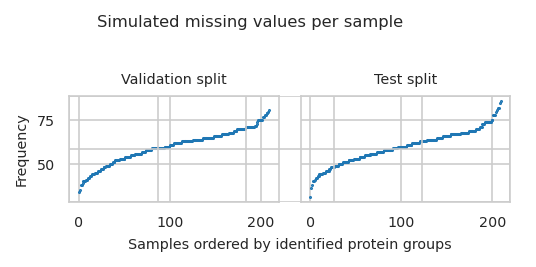

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)

vaep.plotting.data.plot_observations(data.val_y.unstack(), ax=axes[0],
                                     title='Validation split', size=1, xlabel='')
vaep.plotting.data.plot_observations(data.test_y.unstack(), ax=axes[1],
                                     title='Test split', size=1, xlabel='')
fig.suptitle("Simulated missing values per sample", size=8)
# hide axis and use only for common x label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(f'Samples ordered by identified {data.val_y.index.names[-1]}')
group = 1
fname = args.out_figures / f'2_{group}_fake_na_val_test_splits.png'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

## data completeness across entire data

In [12]:
# load frequency of training features...
# needs to be pickle -> index.name needed
freq_feat = vaep.io.datasplits.load_freq(args.data, file='freq_features.json')
freq_feat.head()  # training data

A0A024QZX5;A0A087X1N8;P35237                                                     197
A0A024R0T9;K7ER74;P02655                                                         208
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   185
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          208
A0A075B6H7                                                                        97
Name: freq, dtype: int64

<Axes: xlabel='protein groups', ylabel='Proportion of identification in samples'>

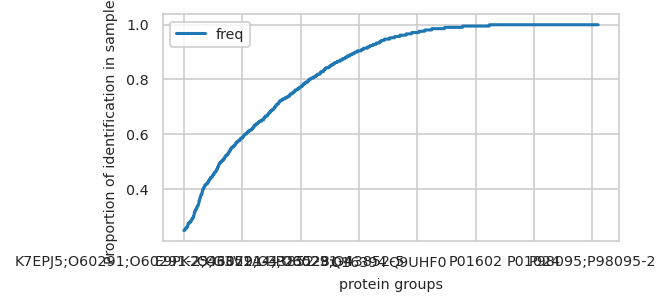

In [13]:
prop = freq_feat / len(data.train_X.index.levels[0])
prop.sort_values().to_frame().plot(
    xlabel=f'{data.val_y.index.names[-1]}',
    ylabel='Proportion of identification in samples')

View training data in wide format

In [14]:
data.to_wide_format()
data.train_X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,NaN,15.050,16.842,NaN,NaN,19.563,NaN,12.805
Sample_001,NaN,16.874,15.519,16.387,NaN,19.941,18.786,17.144,NaN,19.067,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,NaN,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,NaN,12.445
Sample_004,15.603,15.331,15.375,16.679,NaN,20.450,18.682,17.081,14.140,19.686,...,14.757,NaN,NaN,15.256,17.075,19.582,15.328,NaN,13.145,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,NaN,17.705,17.039,NaN,16.413,19.102,...,NaN,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,NaN
Sample_206,15.798,17.554,15.600,15.938,NaN,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,NaN,15.345,17.084,18.708,NaN,19.433,NaN,NaN
Sample_207,15.739,NaN,15.469,16.898,NaN,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,NaN,18.725,16.138,19.599,13.637,11.174


Number of samples and features:

In [15]:
N_SAMPLES, M_FEAT = data.train_X.shape
print(f"N samples: {N_SAMPLES:,d}, M features: {M_FEAT}")

N samples: 210, M features: 1421


Collect outputs in excel file:

In [16]:
fname = args.folder_experiment / '01_2_performance_summary.xlsx'
dumps[fname.stem] = fname
writer = pd.ExcelWriter(fname)
print(f"Saving to: {fname}")

Saving to: runs/alzheimer_study_2023_11_v2/01_2_performance_summary.xlsx


## Model specifications
- used for bar plot annotations

In [17]:
# model_key could be used as key from config file
? load only specified configs?
? case: no config file available?
all_configs = collect(
    paths=(fname for fname in args.out_models.iterdir()
           if fname.suffix == '.yaml'
           and 'model_config' in fname.name),
    load_fn=load_config_file
)
model_configs = pd.DataFrame(all_configs).set_index('model')
model_configs.T.to_excel(writer, sheet_name='model_params')
model_configs.T

Object `configs` not found.
Object `available` not found.


model,Median,KNN,CF,VAE,DAE
M,1421,1421,1421,1421,1421
data,runs/alzheimer_study_2023_11_v2/data,runs/alzheimer_study_2023_11_v2/data,runs/alzheimer_study_2023_11_v2/data,runs/alzheimer_study_2023_11_v2/data,runs/alzheimer_study_2023_11_v2/data
file_format,csv,csv,csv,csv,csv
fn_rawfile_metadata,https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv,https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv,https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv,https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv,https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv
folder_experiment,runs/alzheimer_study_2023_11_v2,runs/alzheimer_study_2023_11_v2,runs/alzheimer_study_2023_11_v2,runs/alzheimer_study_2023_11_v2,runs/alzheimer_study_2023_11_v2
meta_cat_col,NaN,NaN,NaN,NaN,NaN
meta_date_col,NaN,NaN,NaN,NaN,NaN
model_key,Median,KNN,CF,VAE,DAE
n_params,1421,1,83283,277998,184983
out_figures,runs/alzheimer_study_2023_11_v2/figures,runs/alzheimer_study_2023_11_v2/figures,runs/alzheimer_study_2023_11_v2/figures,runs/alzheimer_study_2023_11_v2/figures,runs/alzheimer_study_2023_11_v2/figures


Set Feature name (columns are features, rows are samples)

In [18]:
# index name
freq_feat.index.name = data.train_X.columns.name
# sample index name
sample_index_name = data.train_X.index.name

# Load predictions on validation and test data split


## Validation data
- set top N models to plot based on validation data split

In [19]:
pred_val = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='val',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
SAMPLE_ID, FEAT_NAME = pred_val.index.names
if not FEAT_NAME_DISPLAY:
    FEAT_NAME_DISPLAY = FEAT_NAME
pred_val[MODELS]

,,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,,,
Sample_158,Q9UN70;Q9UN70-2,15.752,15.708,15.673,15.727,15.427,15.469,16.800,NaN,NaN,15.871,...,"2,513.638",6.851,8.369,12.201,14.661,15.620,15.752,17.206,15.700,0
Sample_050,Q9Y287,17.221,16.192,16.602,16.737,17.776,16.453,17.288,NaN,16.106,17.472,...,19.829,7.022,8.482,14.594,16.107,17.076,17.221,17.807,16.738,0
Sample_107,Q8N475;Q8N475-2,14.846,14.369,14.430,14.612,14.150,13.110,17.187,NaN,"2,582.130",12.680,...,"2,582.130",6.050,7.481,13.848,12.252,14.559,14.846,17.434,13.776,0
Sample_199,P06307,18.973,19.312,18.888,18.942,19.247,19.639,16.711,NaN,NaN,19.632,...,"2,483.120",8.465,9.476,11.385,17.603,19.180,18.973,17.111,19.015,0
Sample_067,Q5VUB5,14.726,14.857,15.029,14.952,15.232,15.465,16.743,NaN,NaN,15.976,...,"2,569.564",6.207,7.657,11.797,13.227,14.989,14.726,17.031,14.699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.918,22.777,22.958,22.834,22.884,22.994,17.042,NaN,"2,634.108",22.983,...,"2,634.108",10.296,10.906,12.543,22.004,23.067,22.918,17.330,22.872,0
Sample_002,A0A0A0MT36,15.877,16.052,16.022,15.871,16.857,15.882,16.792,NaN,NaN,17.237,...,"2,448.503",6.328,7.848,12.510,13.167,16.118,15.877,16.879,15.671,0
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,16.278,15.715,16.077,15.817,15.840,15.406,17.032,NaN,"2,487.550",15.313,...,"2,487.550",6.223,8.155,13.038,14.675,15.927,16.278,17.215,15.574,0


Describe absolute error

In [20]:
errors_val = (pred_val
              .drop(TARGET_COL, axis=1)
              .sub(pred_val[TARGET_COL], axis=0)
              [MODELS])
errors_val  # over all samples and all features

,,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,,,
Sample_158,Q9UN70;Q9UN70-2,1.122,1.077,1.042,1.096,0.797,0.839,2.169,NaN,NaN,1.240,...,"2,499.008",-7.779,-6.261,-2.429,0.030,0.990,1.122,2.575,1.070,-14.630
Sample_050,Q9Y287,1.466,0.437,0.847,0.982,2.021,0.698,1.533,NaN,0.351,1.717,...,4.074,-8.733,-7.273,-1.161,0.352,1.321,1.466,2.052,0.983,-15.755
Sample_107,Q8N475;Q8N475-2,-0.183,-0.660,-0.599,-0.418,-0.880,-1.919,2.157,NaN,"2,567.100",-2.350,...,"2,567.100",-8.980,-7.548,-1.182,-2.778,-0.470,-0.183,2.405,-1.253,-15.029
Sample_199,P06307,-0.403,-0.064,-0.488,-0.434,-0.129,0.263,-2.665,NaN,NaN,0.256,...,"2,463.744",-10.911,-9.900,-7.991,-1.773,-0.195,-0.403,-2.265,-0.360,-19.376
Sample_067,Q5VUB5,-0.583,-0.452,-0.280,-0.357,-0.077,0.156,1.434,NaN,NaN,0.668,...,"2,554.255",-9.101,-7.652,-3.512,-2.082,-0.320,-0.583,1.723,-0.610,-15.309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_111,F6SYF8;Q9UBP4,0.096,-0.045,0.136,0.012,0.062,0.171,-5.781,NaN,"2,611.285",0.161,...,"2,611.285",-12.526,-11.916,-10.279,-0.819,0.245,0.096,-5.493,0.050,-22.822
Sample_002,A0A0A0MT36,-2.288,-2.113,-2.143,-2.294,-1.308,-2.283,-1.373,NaN,NaN,-0.928,...,"2,430.338",-11.837,-10.318,-5.655,-4.998,-2.047,-2.288,-1.286,-2.494,-18.165
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,0.753,0.190,0.552,0.292,0.314,-0.120,1.507,NaN,"2,472.025",-0.212,...,"2,472.025",-9.302,-7.371,-2.487,-0.851,0.402,0.753,1.690,0.049,-15.525


### Select top N for plotting and set colors

In [21]:
ORDER_MODELS = (errors_val
                .abs()
                .mean()
                .sort_values()
                .index
                .to_list())
ORDER_MODELS

['BPCA',
 'VAE',
 'DAE',
 'CF',
 'TRKNN',
 'RF',
 'KNN',
 'KNN_IMPUTE',
 'IRM',
 'Median',
 'ROWMEDIAN',
 'LLS',
 'QRILC',
 'COLMEDIAN',
 'SVDMETHOD',
 'PI',
 'MINDET',
 'MINPROB',
 'MSIMPUTE_MNAR',
 'MINIMUM',
 'MSIMPUTE',
 'ZERO',
 'MLE',
 'IMPSEQROB',
 'IMPSEQ']

In [22]:
pred_val = pred_val[[TARGET_COL] + ORDER_MODELS]
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_val.csv'
    dumps[fname.stem] = fname
    pred_val.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_val

,,observed,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,...,PI,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,,,
Sample_158,Q9UN70;Q9UN70-2,14.630,15.469,15.727,15.673,15.708,15.700,15.620,15.427,15.937,15.871,...,12.201,11.916,12.252,8.369,7.068,6.851,0,"2,513.638",NaN,NaN
Sample_050,Q9Y287,15.755,16.453,16.737,16.602,16.192,16.738,17.076,17.776,16.961,17.472,...,14.594,12.900,13.849,8.482,7.068,7.022,0,19.829,16.106,NaN
Sample_107,Q8N475;Q8N475-2,15.029,13.110,14.612,14.430,14.369,13.776,14.559,14.150,15.437,12.680,...,13.848,12.313,12.241,7.481,7.068,6.050,0,"2,582.130","2,582.130",NaN
Sample_199,P06307,19.376,19.639,18.942,18.888,19.312,19.015,19.180,19.247,18.861,19.632,...,11.385,12.285,12.255,9.476,7.068,8.465,0,"2,483.120",NaN,NaN
Sample_067,Q5VUB5,15.309,15.465,14.952,15.029,14.857,14.699,14.989,15.232,15.079,15.976,...,11.797,11.827,11.195,7.657,7.068,6.207,0,"2,569.564",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822,22.994,22.834,22.958,22.777,22.872,23.067,22.884,22.837,22.983,...,12.543,12.161,12.982,10.906,7.068,10.296,0,"2,634.108","2,634.108",NaN
Sample_002,A0A0A0MT36,18.165,15.882,15.871,16.022,16.052,15.671,16.118,16.857,15.446,17.237,...,12.510,12.586,13.131,7.848,7.068,6.328,0,"2,448.503",NaN,NaN
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525,15.406,15.817,16.077,15.715,15.574,15.927,15.840,15.995,15.313,...,13.038,12.352,13.174,8.155,7.068,6.223,0,"2,487.550","2,487.550",NaN


In [23]:
mae_stats_ordered_val = errors_val.abs().describe()[ORDER_MODELS]
mae_stats_ordered_val.to_excel(writer, sheet_name='mae_stats_ordered_val', float_format='%.5f')
mae_stats_ordered_val.T

,count,mean,std,min,25%,50%,75%,max
BPCA,"12,600.000",0.422,0.501,0.000,0.119,0.269,0.534,9.370
VAE,"12,600.000",0.434,0.523,0.000,0.122,0.278,0.543,9.769
DAE,"12,600.000",0.436,0.523,0.000,0.120,0.279,0.546,9.781
CF,"12,600.000",0.444,0.505,0.000,0.133,0.296,0.567,7.951
TRKNN,"12,600.000",0.450,0.516,0.000,0.132,0.295,0.569,7.975
RF,"12,600.000",0.463,0.530,0.000,0.133,0.308,0.594,7.506
KNN,"12,600.000",0.481,0.565,0.000,0.138,0.310,0.618,10.502
KNN_IMPUTE,"12,600.000",0.554,0.668,0.000,0.164,0.359,0.692,7.550
IRM,"12,600.000",0.588,0.637,0.000,0.176,0.396,0.767,7.953
Median,"12,600.000",0.598,0.639,0.000,0.189,0.419,0.778,9.014


Some model have fixed colors, others are assigned randomly

> Note
>
> 1. The order of "new" models is important for the color assignment.
> 2. User defined model keys for the same model with two configuration will yield different colors.

In [24]:
COLORS_TO_USE = vaep.plotting.defaults.assign_colors(list(k.upper() for k in ORDER_MODELS))
vaep.plotting.defaults.ModelColorVisualizer(ORDER_MODELS, COLORS_TO_USE)

vaep.plotting.defaults - INFO     Reused some colors!


In [25]:
TOP_N_ORDER = ORDER_MODELS[:args.plot_to_n]
TOP_N_COLOR_PALETTE = {model: color for model,
                       color in zip(TOP_N_ORDER, COLORS_TO_USE)}
TOP_N_ORDER

['BPCA', 'VAE', 'DAE', 'CF', 'TRKNN']

### Correlation per sample

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_pred_corr_val_per_sample.pdf


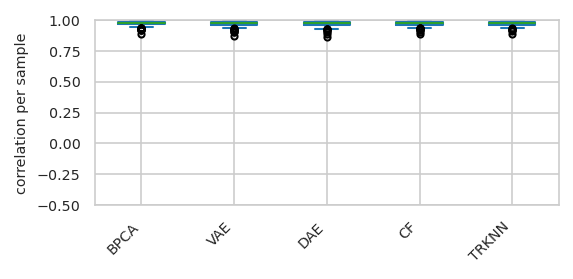

In [26]:
corr_per_sample_val = (pred_val
                       .groupby(sample_index_name)
                       .apply(
                           lambda df: df.corr().loc[TARGET_COL]
                       )[ORDER_MODELS])

min_corr = int(corr_per_sample_val.min().min() * 10) / 10
kwargs = dict(ylim=(min_corr, 1), rot=90,
              #     boxprops=dict(linewidth=1.5),
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model pred. per sample on validation data',
              ylabel='correlation per sample')
ax = corr_per_sample_val[TOP_N_ORDER].plot.box(**kwargs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.xlsx'
dumps[fname.stem] = fname
with pd.ExcelWriter(fname) as w:
    corr_per_sample_val.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_val.to_excel(w, sheet_name='correlations')
    corr_per_sample_val[TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

identify samples which are below lower whisker for models

In [27]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_sample_val[TOP_N_ORDER]).min()
mask = (corr_per_sample_val[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_val.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

observed,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,Median,ROWMEDIAN,LLS,QRILC,COLMEDIAN,SVDMETHOD,PI,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ
Sample ID,,,,,,,,,,,,,,,,,,,,,,,,,
Sample_054,0.932254,0.931280,0.910396,0.938368,0.910271,0.925703,0.925876,0.905679,0.913765,0.915748,0.915748,0.929264,0.852977,nan,0.190649,-0.058580,nan,-0.014631,0.851409,nan,0.844387,nan,nan,0.029777,nan
Sample_063,0.970046,0.928239,0.943646,0.956494,0.961257,0.947456,0.931853,0.928428,0.926100,0.929356,0.929356,0.947981,0.891019,nan,0.294161,0.055149,nan,-0.152103,0.873367,nan,0.884744,nan,nan,nan,nan
Sample_071,0.887866,0.910405,0.905739,0.886179,0.888162,0.894762,0.895286,0.880453,0.865003,0.885806,0.885806,0.899799,0.841520,nan,0.178303,-0.002523,nan,0.023515,0.844543,nan,0.846605,nan,nan,nan,nan
Sample_073,0.930349,0.915927,0.925504,0.921380,0.919876,0.908927,0.950641,0.916774,0.901773,0.900178,0.900178,0.909057,0.899796,nan,-0.017963,-0.165299,nan,0.200512,0.867661,nan,0.873957,nan,nan,nan,nan
Sample_095,0.940942,0.917923,0.919825,0.932428,0.927289,0.911186,0.930902,0.909714,0.913905,0.878167,0.878167,0.917350,0.798668,nan,-0.120269,-0.015152,nan,-0.112745,0.783033,nan,0.786884,nan,nan,nan,nan
Sample_133,0.919483,0.928445,0.931790,0.923834,0.928251,0.928853,0.903370,0.885348,0.878925,0.899233,0.899233,0.881238,0.847761,nan,0.219841,0.098983,nan,-0.165541,0.800811,nan,0.805345,nan,nan,nan,nan
Sample_139,0.927681,0.937851,0.931146,0.933411,0.957367,0.921978,0.901552,0.878475,0.891290,0.907333,0.907333,0.928867,0.830235,nan,0.156894,-0.245933,nan,-0.020822,0.833696,nan,0.821784,nan,nan,nan,nan
Sample_143,0.960211,0.940457,0.942527,0.924581,0.941251,0.925954,0.906412,0.918646,0.937540,0.923908,0.923908,0.938984,0.899983,nan,0.252475,-0.061421,nan,0.047188,0.824597,nan,0.835467,nan,nan,nan,nan
Sample_150,0.950334,0.899421,0.888564,0.937473,0.945063,0.910441,0.868275,0.930981,0.907850,0.892997,0.892997,0.940619,0.828291,nan,0.166841,-0.010551,nan,-0.113795,0.841852,nan,0.846448,nan,nan,nan,nan


### Error plot

In [28]:
c_error_min = 4.5
mask = (errors_val[MODELS].abs() > c_error_min).any(axis=1)
errors_val.loc[mask].sort_index(level=1).head()

,,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,,,
Sample_012,A0A024QZX5;A0A087X1N8;P35237,-0.324,-0.190,-0.273,-0.298,-0.246,-0.140,0.856,NaN,NaN,-0.366,...,0.632,-9.244,-7.824,-2.861,-1.111,-0.347,-0.324,1.241,-0.318,-15.949
Sample_017,A0A024QZX5;A0A087X1N8;P35237,0.347,0.122,0.363,0.334,-0.093,0.251,1.658,NaN,NaN,0.363,...,1.228,-8.634,-7.430,-1.408,-0.888,0.278,0.347,2.214,0.305,-15.279
Sample_050,A0A024QZX5;A0A087X1N8;P35237,0.544,0.071,-0.033,0.147,0.024,0.178,2.207,NaN,NaN,0.424,...,3.294,-8.767,-7.273,-0.690,-0.286,0.103,0.544,2.691,0.238,-15.081
Sample_102,A0A024QZX5;A0A087X1N8;P35237,-0.029,-0.075,-0.077,-0.092,0.030,-0.107,0.942,NaN,NaN,-0.309,...,1.609,-8.696,-7.621,-2.980,-1.072,0.015,-0.029,1.168,-0.065,-15.654
Sample_109,A0A024QZX5;A0A087X1N8;P35237,0.343,-0.073,-0.123,0.051,-0.179,-0.263,1.518,NaN,"2,689.152",-0.369,...,-2.077,-8.663,-7.295,-3.410,-0.373,0.090,0.343,1.968,-0.012,-15.283


In [29]:
errors_val = errors_val.abs().groupby(
    freq_feat.index.name).mean()  # absolute error
errors_val = errors_val.join(freq_feat)
errors_val = errors_val.sort_values(by=freq_feat.name, ascending=True)
errors_val.head()

,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO,freq
protein groups,,,,,,,,,,,,,,,,,,,,,
K7EPJ5;O60291;O60291-2;O60291-3;O60291-4,0.331,0.543,0.450,0.350,0.281,0.387,3.029,NaN,"2,481.425",0.477,...,11.830,9.649,1.286,1.830,0.315,0.331,3.452,0.257,13.857,52
Q9Y281;Q9Y281-3,0.415,0.257,0.332,0.342,0.325,0.266,4.078,NaN,"2,521.426",1.083,...,10.549,8.358,0.620,1.145,0.357,0.415,4.472,0.307,12.573,52
B1AJQ6;Q86Y82,1.082,1.036,0.155,0.028,0.482,0.674,3.367,NaN,NaN,1.275,...,11.053,8.934,0.267,6.918,0.868,1.082,3.926,0.900,13.380,52
H0Y7T8;P49418;P49418-2,0.482,0.379,0.319,0.307,0.637,0.430,1.860,NaN,"2,552.042",0.678,...,12.641,10.326,2.085,4.232,0.305,0.482,2.310,0.497,15.071,53
A0A0C4DH29,0.556,0.501,0.618,0.577,0.561,0.410,1.629,NaN,NaN,0.387,...,12.703,10.534,2.853,1.927,0.428,0.556,2.029,0.596,15.206,53


In [30]:
errors_val.describe()[ORDER_MODELS].T  # mean of means

,count,mean,std,min,25%,50%,75%,max
BPCA,"1,419.000",0.408,0.306,0.017,0.222,0.320,0.494,4.195
VAE,"1,419.000",0.422,0.321,0.028,0.230,0.333,0.491,3.389
DAE,"1,419.000",0.422,0.328,0.027,0.228,0.326,0.500,3.275
CF,"1,419.000",0.433,0.298,0.037,0.244,0.352,0.519,3.173
TRKNN,"1,419.000",0.437,0.309,0.000,0.241,0.349,0.526,3.647
RF,"1,419.000",0.451,0.322,0.046,0.254,0.364,0.529,3.956
KNN,"1,419.000",0.468,0.333,0.012,0.267,0.375,0.549,3.693
KNN_IMPUTE,"1,419.000",0.531,0.378,0.063,0.296,0.424,0.636,3.430
IRM,"1,419.000",0.555,0.372,0.030,0.311,0.449,0.674,3.476
Median,"1,419.000",0.580,0.359,0.094,0.351,0.487,0.691,4.171


In [31]:
c_avg_error = 2
mask = (errors_val[TOP_N_ORDER] >= c_avg_error).any(axis=1)
errors_val.loc[mask]

,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO,freq
protein groups,,,,,,,,,,,,,,,,,,,,,
O60512,2.233,2.104,2.087,1.882,2.293,1.989,5.769,NaN,NaN,2.246,...,8.715,6.501,2.930,3.743,2.076,2.233,6.098,2.559,10.910,58
P18206;P18206-2,2.427,2.023,1.993,1.948,1.744,1.297,3.821,NaN,"2,678.195",1.592,...,8.936,7.171,0.998,1.763,2.091,2.427,4.085,1.581,12.898,97
Q99538,2.502,2.394,2.322,2.218,2.711,2.464,2.615,NaN,NaN,2.336,...,10.124,8.405,2.436,3.200,2.453,2.502,2.767,2.399,14.984,107
P02100,2.192,2.295,1.998,2.628,2.283,1.033,1.996,NaN,NaN,1.662,...,10.421,8.927,3.700,5.307,2.411,2.192,2.106,1.856,16.373,127
A0A0G2JRN3,3.053,3.173,3.275,3.389,3.693,4.195,3.998,NaN,"2,519.362",3.363,...,12.599,11.172,6.992,6.169,3.956,3.053,3.976,3.647,19.496,128
P01817,2.254,1.989,2.178,1.941,1.963,2.385,2.736,NaN,"2,562.195",2.428,...,9.247,7.520,2.443,3.366,1.909,2.254,3.104,2.039,14.053,133
Q15375;Q15375-4,4.171,1.638,1.549,1.668,1.608,1.981,3.754,NaN,"2,470.696",3.304,...,10.990,9.932,6.040,4.865,2.039,4.171,3.566,2.065,19.101,163
P68871,2.331,1.576,2.302,2.391,1.616,0.571,1.720,NaN,"1,676.498",1.534,...,9.162,7.803,3.405,3.793,2.012,2.331,2.014,0.854,16.378,168
P69905,2.793,2.313,3.045,2.922,2.936,1.032,2.807,NaN,"2,621.218",2.055,...,10.518,9.413,5.646,6.490,2.695,2.793,2.626,1.016,18.200,190


### Error by non-decimal number of intensity
- number of observations in parentheses.

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_errors_binned_by_feat_median_val.pdf


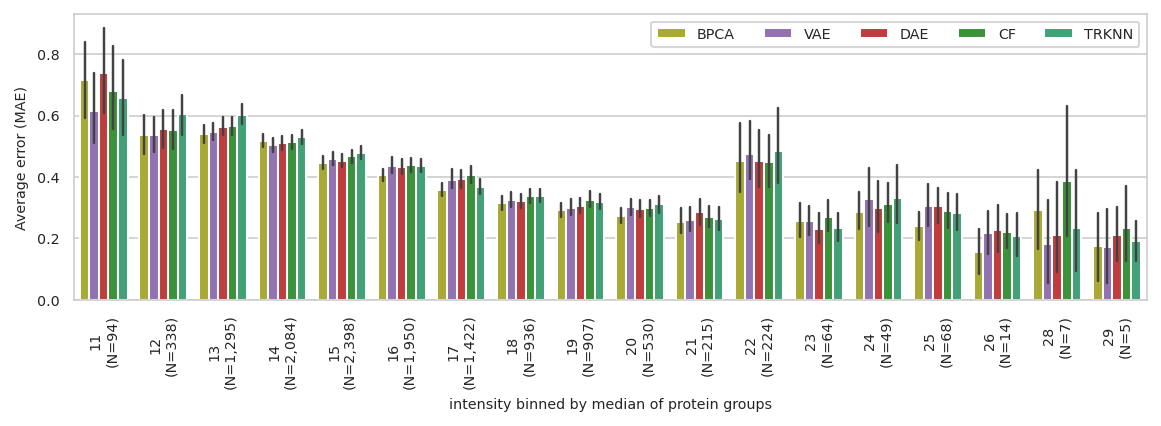

In [32]:
fig, ax = plt.subplots(figsize=(8, 3))
ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
    pred_val[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,)
ax.set_ylabel(f"Average error ({METRIC})")
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_errors_binned_by_feat_median_val.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

In [33]:
# ! only used for reporting
plotted = vaep.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

,bin,model,mean,ci_low,ci_high
0,11\n(N=94),BPCA,0.715,0.598,0.844
1,11\n(N=94),VAE,0.613,0.502,0.732
2,11\n(N=94),DAE,0.740,0.594,0.880
3,11\n(N=94),CF,0.679,0.552,0.817
4,11\n(N=94),TRKNN,0.655,0.537,0.777
...,...,...,...,...,...
85,29\n(N=5),BPCA,0.175,0.062,0.288
86,29\n(N=5),VAE,0.171,0.051,0.306
87,29\n(N=5),DAE,0.212,0.137,0.297
88,29\n(N=5),CF,0.235,0.128,0.382


In [34]:
errors_binned.head()
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

,Sample ID,protein groups,model,MAE,bin,n_obs,intensity binned by median of protein groups
0,Sample_158,Q9UN70;Q9UN70-2,BPCA,0.839,15,"2,398","15\n(N=2,398)"
1,Sample_158,Q9UN70;Q9UN70-2,VAE,1.096,15,"2,398","15\n(N=2,398)"
2,Sample_158,Q9UN70;Q9UN70-2,DAE,1.042,15,"2,398","15\n(N=2,398)"
3,Sample_158,Q9UN70;Q9UN70-2,CF,1.077,15,"2,398","15\n(N=2,398)"
4,Sample_158,Q9UN70;Q9UN70-2,TRKNN,1.070,15,"2,398","15\n(N=2,398)"


## test data

In [35]:
pred_test = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='test',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
pred_test = pred_test[[TARGET_COL] + ORDER_MODELS]
pred_test = pred_test.join(freq_feat, on=freq_feat.index.name)
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_test.csv'
    dumps[fname.stem] = fname
    pred_test.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_test

observed  \
Sample ID  protein groups                                                        
Sample_000 A0A075B6P5;P01615                                            17.016   
           A0A087X089;Q16627;Q16627-2                                   18.280   
           A0A0B4J2B5;S4R460                                            21.735   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                              14.603   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4    16.143   
...                                                                        ...   
Sample_209 Q96ID5                                                       16.074   
           Q9H492;Q9H492-2                                              13.173   
           Q9HC57                                                       14.207   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                     14.962   
           Q9UGM5;Q9UGM5-2                                              16.871   

                                                                       BPCA  \
Sample ID  protein groups                                                     
Sample_000 A0A075B6P5;P01615                                         17.483   
           A0A087X089;Q16627;Q16627-2                                17.769   
           A0A0B4J2B5;S4R460                                         22.459   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.285   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.583   
...                                                                     ...   
Sample_209 Q96ID5                                                    15.866   
           Q9H492;Q9H492-2                                           13.249   
           Q9HC57                                                    13.756   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.096   
           Q9UGM5;Q9UGM5-2                                           16.395   

                                                                        VAE  \
Sample ID  protein groups                                                     
Sample_000 A0A075B6P5;P01615                                         17.273   
           A0A087X089;Q16627;Q16627-2                                17.826   
           A0A0B4J2B5;S4R460                                         22.240   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.311   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.711   
...                                                                     ...   
Sample_209 Q96ID5                                                    15.994   
           Q9H492;Q9H492-2                                           13.257   
           Q9HC57                                                    14.122   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.088   
           Q9UGM5;Q9UGM5-2                                           16.398   

                                                                        DAE  \
Sample ID  protein groups                                                     
Sample_000 A0A075B6P5;P01615                                         16.972   
           A0A087X089;Q16627;Q16627-2                                18.253   
           A0A0B4J2B5;S4R460                                         22.135   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.469   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.775   
...                                                                     ...   
Sample_209 Q96ID5                                                    15.811   
           Q9H492;Q9H492-2                                           13.452   
           Q9HC57                                                    13.972   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.289   

Write averages for all models to excel (from before?)

In [36]:
errors_test_mae = vaep.pandas.calc_errors.get_absolute_error(
    pred_test
)
mae_stats_ordered_test = errors_test_mae.describe()[ORDER_MODELS]
mae_stats_ordered_test

,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,Median,...,PI,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ
count,"12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000",...,"12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","12,600.000","2,976.000",0.000
mean,0.432,0.438,0.441,0.450,0.458,0.466,0.482,0.558,0.587,0.602,...,3.805,4.109,4.122,8.324,9.271,9.677,16.339,"2,186.302","2,451.991",NaN
std,0.518,0.542,0.541,0.517,0.539,0.540,0.562,0.679,0.647,0.643,...,2.684,2.667,2.712,1.594,2.741,1.441,2.741,853.899,464.069,NaN
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.001,0.003,0.003,0.869,0.141,2.485,7.209,0.001,0.014,NaN
25%,0.121,0.120,0.123,0.134,0.132,0.136,0.140,0.163,0.175,0.195,...,1.749,2.132,2.118,7.301,7.344,8.761,14.412,"2,436.455","2,475.170",NaN
50%,0.280,0.273,0.278,0.297,0.299,0.306,0.316,0.364,0.394,0.424,...,3.334,3.635,3.648,8.131,8.867,9.520,15.935,"2,496.971","2,525.227",NaN
75%,0.546,0.549,0.554,0.576,0.584,0.587,0.612,0.703,0.762,0.785,...,5.337,5.610,5.677,9.143,10.842,10.458,17.910,"2,555.017","2,589.788",NaN
max,7.635,9.140,8.989,6.959,9.111,6.865,8.171,9.005,7.829,10.292,...,18.116,18.317,18.443,16.866,23.072,18.270,30.140,"2,873.005","2,873.005",NaN


In [37]:
mae_stats_ordered_test.to_excel(writer, sheet_name='mae_stats_ordered_test', float_format='%.5f')

In [38]:
cp_mean_perf = pd.concat([
    mae_stats_ordered_val.loc['mean'],
    mae_stats_ordered_test.loc['mean'],
],
    axis=1,
    keys=['val', 'test']
).sort_values(by='val')
cp_mean_perf.to_excel(writer, sheet_name='cp_mean_perf', float_format='%.5f')
cp_mean_perf

,val,test
BPCA,0.422,0.432
VAE,0.434,0.438
DAE,0.436,0.441
CF,0.444,0.450
TRKNN,0.450,0.458
RF,0.463,0.466
KNN,0.481,0.482
KNN_IMPUTE,0.554,0.558
IRM,0.588,0.587
Median,0.598,0.602


In [39]:
writer.close()

### Intensity distribution as histogram
Plot top 4 models predictions for intensities in test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_intensity_binned_top_4_models_test.pdf


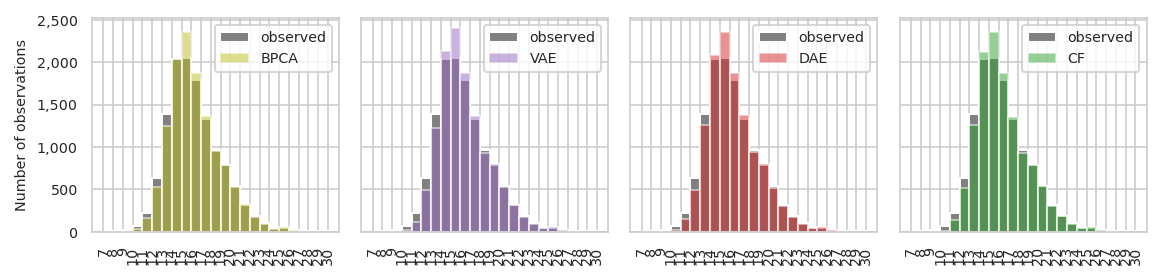

In [40]:
min_max = vaep.plotting.data.min_max(pred_test[TARGET_COL])
top_n = 4
fig, axes = plt.subplots(ncols=top_n, figsize=(8, 2), sharey=True)

for model, color, ax in zip(
        ORDER_MODELS[:top_n],
        COLORS_TO_USE[:top_n],
        axes):

    ax, bins = vaep.plotting.data.plot_histogram_intensities(
        pred_test[TARGET_COL],
        color='grey',
        min_max=min_max,
        ax=ax
    )
    ax, _ = vaep.plotting.data.plot_histogram_intensities(
        pred_test[model],
        color=color,
        min_max=min_max,
        ax=ax,
        alpha=0.5,
    )
    _ = [(l_.set_rotation(90))
         for l_ in ax.get_xticklabels()]
    ax.legend()

axes[0].set_ylabel('Number of observations')

fname = args.out_figures / f'2_{group}_intensity_binned_top_{top_n}_models_test.pdf'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

In [41]:
counts_per_bin = vaep.pandas.get_counts_per_bin(df=pred_test,
                                                bins=bins,
                                                columns=[TARGET_COL, *ORDER_MODELS[:top_n]])

counts_per_bin.to_excel(fname.with_suffix('.xlsx'))
counts_per_bin

,observed,BPCA,VAE,DAE,CF
bin,,,,,
"(7, 8]",2,0,0,0,0
"(8, 9]",7,0,0,0,0
"(9, 10]",18,2,2,3,0
"(10, 11]",69,29,17,25,14
"(11, 12]",217,165,117,147,134
"(12, 13]",634,531,490,493,520
"(13, 14]","1,394","1,248","1,225","1,264","1,255"
"(14, 15]","2,042","2,033","2,135","2,090","2,115"
"(15, 16]","2,054","2,359","2,403","2,358","2,353"


### Correlation per sample

In [42]:
corr_per_sample_test = (pred_test
                        .groupby(sample_index_name)
                        .apply(lambda df: df.corr().loc[TARGET_COL])
                        [ORDER_MODELS])
corr_per_sample_test = corr_per_sample_test.join(
    pred_test
    .groupby(sample_index_name)[TARGET_COL]
    .count()
    .rename('n_obs')
)
too_few_obs = corr_per_sample_test['n_obs'] < 3
corr_per_sample_test.loc[~too_few_obs].describe()

,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,Median,...,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ,n_obs
count,210.000,210.000,210.000,210.000,210.000,210.000,210.000,210.000,210.000,210.000,...,0.000,210.000,210.000,0.000,210.000,0.000,30.000,7.000,0.000,210.000
mean,0.969,0.967,0.967,0.968,0.966,0.966,0.963,0.948,0.952,0.949,...,NaN,0.003,0.872,NaN,0.877,NaN,-0.018,-0.087,NaN,60.000
std,0.017,0.019,0.018,0.016,0.019,0.017,0.019,0.035,0.022,0.028,...,NaN,0.124,0.041,NaN,0.041,NaN,0.151,0.304,NaN,9.810
min,0.878,0.862,0.900,0.900,0.858,0.891,0.888,0.722,0.865,0.814,...,NaN,-0.304,0.711,NaN,0.708,NaN,-0.287,-0.445,NaN,31.000
25%,0.962,0.962,0.961,0.961,0.960,0.959,0.953,0.938,0.943,0.939,...,NaN,-0.085,0.849,NaN,0.855,NaN,-0.118,-0.287,NaN,53.000
50%,0.973,0.972,0.971,0.972,0.970,0.969,0.968,0.958,0.956,0.956,...,NaN,-0.007,0.880,NaN,0.882,NaN,-0.042,-0.103,NaN,60.000
75%,0.981,0.980,0.980,0.978,0.979,0.978,0.978,0.969,0.966,0.968,...,NaN,0.088,0.902,NaN,0.907,NaN,0.062,0.016,NaN,67.000
max,0.994,0.994,0.991,0.993,0.992,0.991,0.990,0.987,0.988,0.988,...,NaN,0.335,0.944,NaN,0.943,NaN,0.393,0.483,NaN,86.000


vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_pred_corr_test_per_sample.pdf


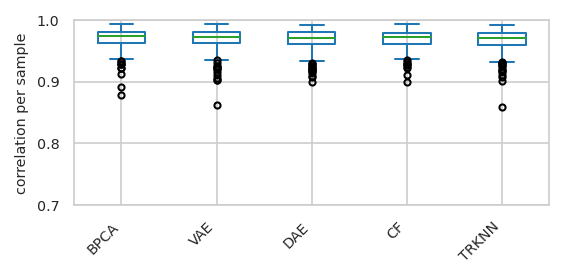

In [43]:
# ! add minimum
kwargs = dict(ylim=(0.7, 1), rot=90,
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model predictions per sample on test data',
              ylabel='correlation per sample')
ax = (corr_per_sample_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_sample.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_sample_test.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_test.to_excel(w, sheet_name='correlations')
    corr_per_sample_test.loc[~too_few_obs, TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

identify samples which are below lower whisker for models

In [44]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_sample_test[TOP_N_ORDER]).min()
mask = (corr_per_sample_test[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_test.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,Median,ROWMEDIAN,LLS,QRILC,COLMEDIAN,SVDMETHOD,PI,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ,n_obs
Sample ID,,,,,,,,,,,,,,,,,,,,,,,,,,
Sample_043,0.949633,0.862313,0.919869,0.899938,0.858409,0.923578,0.888093,0.847971,0.882989,0.814366,0.814366,0.828364,0.781510,nan,-0.060303,-0.181015,nan,-0.038544,0.833336,nan,0.834985,nan,nan,nan,nan,57
Sample_047,0.939299,0.942538,0.908405,0.945219,0.916738,0.935730,0.945377,0.874472,0.900719,0.896683,0.896683,0.009710,0.924163,nan,-0.077002,0.192960,nan,-0.076862,0.871413,nan,0.879766,nan,nan,nan,nan,46
Sample_080,0.922142,0.911630,0.925269,0.911254,0.911596,0.914577,0.921951,0.902040,0.883475,0.893836,0.893836,0.880736,0.860628,nan,0.093012,0.047171,nan,-0.091970,0.850439,nan,0.835250,nan,nan,nan,nan,64
Sample_091,0.878328,0.905675,0.899742,0.923865,0.931055,0.890646,0.903784,0.920915,0.864672,0.903019,0.903019,0.910180,0.802907,nan,-0.095511,0.142881,nan,-0.062885,0.797195,nan,0.803422,nan,nan,nan,nan,60
Sample_108,0.929388,0.946303,0.928939,0.942939,0.940255,0.945102,0.946047,0.866107,0.915455,0.939810,0.939810,0.929216,0.837309,nan,-0.044493,0.039314,nan,0.038170,0.835175,nan,0.846222,nan,nan,nan,nan,68
Sample_109,0.937615,0.923870,0.917754,0.928222,0.924847,0.925750,0.893626,0.841761,0.879726,0.890426,0.890426,0.931145,0.708506,nan,-0.059637,-0.101001,nan,0.257670,0.808222,nan,0.816912,nan,-0.040683,nan,nan,59
Sample_111,0.978525,0.925024,0.952137,0.957066,0.974002,0.932023,0.933775,0.923850,0.935239,0.857016,0.857016,0.962568,0.643926,nan,-0.130888,0.020786,nan,-0.223515,0.710716,nan,0.723039,nan,nan,nan,nan,54
Sample_115,0.891712,0.903218,0.909075,0.928800,0.915296,0.924751,0.918842,0.853242,0.874847,0.881285,0.881285,0.901459,0.778340,nan,0.094778,-0.087979,nan,0.016848,0.833569,nan,0.844090,nan,nan,nan,nan,63
Sample_134,0.933622,0.935903,0.935218,0.931118,0.907465,0.935272,0.935936,0.905001,0.915387,0.865397,0.865397,0.881808,0.872928,nan,0.389792,-0.126113,nan,-0.091518,0.836838,nan,0.843697,nan,nan,nan,nan,66


In [45]:
feature_names = pred_test.index.levels[-1]
N_SAMPLES = pred_test.index
M = len(feature_names)
pred_test.loc[pd.IndexSlice[:, feature_names[random.randint(0, M - 1)]], :]

,,observed,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,...,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ,freq
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,,,
Sample_007,Q8TCZ2,19.288,19.180,19.116,19.046,19.121,19.170,19.158,19.178,19.094,19.124,...,12.712,13.005,9.407,7.068,8.243,0,"2,714.837",NaN,NaN,210
Sample_013,Q8TCZ2,19.479,19.735,19.587,19.458,19.604,19.717,19.579,19.787,19.394,19.795,...,12.688,11.730,9.513,7.068,8.536,0,"2,582.510","2,582.510",NaN,210
Sample_026,Q8TCZ2,19.805,19.714,19.614,19.686,19.738,19.608,19.683,19.528,19.597,20.150,...,12.760,12.714,9.484,7.068,8.460,0,"2,602.921",NaN,NaN,210
Sample_047,Q8TCZ2,18.892,18.788,18.910,18.897,19.031,18.850,19.143,19.272,18.838,18.907,...,12.395,13.020,9.093,7.068,7.985,0,"2,672.609","2,672.609",NaN,210
Sample_060,Q8TCZ2,20.294,20.210,20.137,20.313,20.105,20.356,20.043,20.206,20.104,20.192,...,12.923,13.119,9.904,7.068,8.860,0,"2,480.145",NaN,NaN,210
Sample_064,Q8TCZ2,19.221,19.355,19.284,19.232,19.219,19.291,19.346,19.542,19.277,19.625,...,12.142,12.066,9.604,7.068,8.801,0,"2,578.891",NaN,NaN,210
Sample_067,Q8TCZ2,19.439,19.067,19.090,18.987,19.087,19.143,19.284,19.388,19.120,19.338,...,11.827,12.518,10.311,7.068,9.032,0,"2,569.564",NaN,NaN,210
Sample_071,Q8TCZ2,19.471,19.678,19.604,19.611,19.747,19.562,19.621,19.599,19.582,19.575,...,12.212,12.783,9.758,7.068,9.123,0,"2,443.160",NaN,NaN,210
Sample_108,Q8TCZ2,19.052,18.830,19.172,18.867,18.960,19.533,19.188,19.202,19.208,19.237,...,12.291,13.352,9.301,7.068,8.444,0,"2,654.695","2,654.695",NaN,210


In [46]:
options = random.sample(sorted(set(feature_names)), 1)
pred_test.loc[pd.IndexSlice[:, options[0]], :]

,,observed,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,...,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ,freq
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,,,
Sample_055,Q9NRN5,17.786,17.794,17.733,17.791,17.521,17.974,17.836,17.616,17.978,17.905,...,12.546,12.884,9.244,7.068,7.952,0,"2,555.207",NaN,NaN,210
Sample_069,Q9NRN5,17.452,17.892,17.790,17.674,17.587,17.763,17.677,17.797,17.999,17.635,...,11.631,11.047,9.469,7.068,8.323,0,"2,567.211","2,567.211",NaN,210
Sample_073,Q9NRN5,18.455,18.069,17.985,18.021,17.958,17.815,17.826,18.101,17.819,17.997,...,12.136,13.297,9.200,7.068,8.237,0,"2,563.357",NaN,NaN,210
Sample_107,Q9NRN5,16.719,17.140,17.364,17.107,16.964,17.047,17.565,17.140,17.527,17.391,...,12.313,11.628,8.704,7.068,7.695,0,"2,582.130",NaN,NaN,210
Sample_129,Q9NRN5,17.411,17.407,17.684,17.690,17.597,17.753,17.605,17.587,17.843,17.428,...,11.762,11.773,9.088,7.068,8.169,0,"2,544.946",NaN,NaN,210
Sample_138,Q9NRN5,17.060,17.314,17.563,17.229,17.477,17.347,17.576,17.407,17.537,17.270,...,11.222,11.840,9.064,7.068,7.766,0,"2,498.212",NaN,NaN,210
Sample_174,Q9NRN5,17.986,18.013,17.857,17.839,17.610,18.010,17.763,17.811,17.767,17.896,...,12.727,13.271,9.759,7.068,8.234,0,"2,454.529",NaN,NaN,210
Sample_186,Q9NRN5,17.462,17.692,17.764,17.679,17.693,17.910,17.761,17.831,18.031,17.639,...,12.660,13.165,9.268,7.068,8.344,0,"2,452.355",NaN,NaN,210


### Correlation per feature

In [47]:
corr_per_feat_test = pred_test.groupby(FEAT_NAME).apply(
    lambda df: df.corr().loc[TARGET_COL])[ORDER_MODELS]
corr_per_feat_test = corr_per_feat_test.join(pred_test.groupby(FEAT_NAME)[
    TARGET_COL].count().rename('n_obs'))

too_few_obs = corr_per_feat_test['n_obs'] < 3
corr_per_feat_test.loc[~too_few_obs].describe()

,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,Median,...,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ,n_obs
count,"1,396.000","1,396.000","1,396.000","1,396.000","1,396.000","1,396.000","1,396.000","1,396.000","1,396.000",0.000,...,"1,396.000","1,396.000","1,396.000",0.000,"1,396.000",0.000,"1,396.000",631.000,0.000,"1,396.000"
mean,0.636,0.625,0.634,0.622,0.607,0.589,0.538,0.445,0.470,NaN,...,0.086,0.046,0.081,NaN,0.095,NaN,-0.016,-0.132,NaN,8.999
std,0.337,0.341,0.338,0.337,0.342,0.346,0.369,0.422,0.388,NaN,...,0.441,0.424,0.439,NaN,0.471,NaN,0.433,0.746,NaN,3.913
min,-0.998,-0.994,-0.960,-0.943,-0.977,-0.982,-0.991,-1.000,-0.999,NaN,...,-0.999,-0.979,-1.000,NaN,-0.996,NaN,-0.999,-1.000,NaN,3.000
25%,0.506,0.499,0.498,0.472,0.455,0.440,0.359,0.221,0.266,NaN,...,-0.242,-0.241,-0.210,NaN,-0.252,NaN,-0.313,-0.912,NaN,6.000
50%,0.746,0.736,0.740,0.725,0.706,0.697,0.634,0.554,0.554,NaN,...,0.118,0.058,0.087,NaN,0.118,NaN,-0.016,-0.239,NaN,8.000
75%,0.880,0.873,0.875,0.871,0.859,0.841,0.809,0.770,0.768,NaN,...,0.425,0.357,0.398,NaN,0.468,NaN,0.294,0.572,NaN,11.000
max,0.999,0.999,0.998,1.000,1.000,0.999,1.000,1.000,0.998,NaN,...,0.999,0.993,0.998,NaN,1.000,NaN,0.998,1.000,NaN,32.000


In [48]:
corr_per_feat_test.loc[too_few_obs].dropna(thresh=3, axis=0)

,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,Median,...,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ,n_obs
protein groups,,,,,,,,,,,,,,,,,,,,,
A0A0A0MS09;P01880;P01880-2,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,1.000,1.000,NaN,...,-1.000,1.000,-1.000,NaN,-1.000,NaN,-1.000,NaN,NaN,2
A0A0C4DGV4;E9PLX3;O43504;R4GMU8,1.000,1.000,1.000,1.000,-1.000,1.000,1.000,1.000,1.000,NaN,...,-1.000,1.000,1.000,NaN,-1.000,NaN,1.000,NaN,NaN,2
A0A0C4DH29,-1.000,1.000,-1.000,-1.000,-1.000,1.000,-1.000,1.000,1.000,NaN,...,-1.000,-1.000,1.000,NaN,1.000,NaN,-1.000,NaN,NaN,2
A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3,-1.000,1.000,-1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,NaN,...,1.000,1.000,-1.000,NaN,1.000,NaN,-1.000,NaN,NaN,2
A6H8L4;E7EUI5;P78536;P78536-2,1.000,-1.000,1.000,1.000,-1.000,-1.000,1.000,-1.000,1.000,NaN,...,-1.000,-1.000,1.000,NaN,1.000,NaN,-1.000,NaN,NaN,2
D6RF35,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,...,-1.000,-1.000,-1.000,NaN,1.000,NaN,1.000,1.000,NaN,2
E7EQ64;P07477,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,NaN,...,-1.000,-1.000,-1.000,NaN,-1.000,NaN,-1.000,NaN,NaN,2
F8WDW9;Q96AP7,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,NaN,...,-1.000,-1.000,-1.000,NaN,-1.000,NaN,1.000,1.000,NaN,2
J3KRP0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,NaN,...,1.000,-1.000,-1.000,NaN,-1.000,NaN,1.000,NaN,NaN,2


vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_pred_corr_test_per_feat.pdf


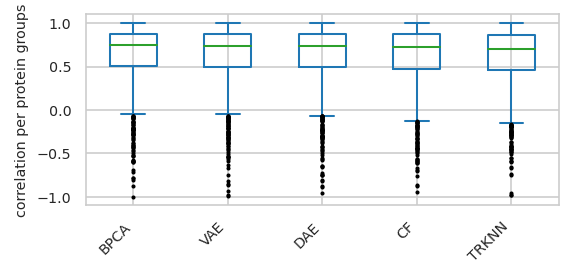

In [49]:
kwargs = dict(rot=90,
              flierprops=dict(markersize=1),
              ylabel=f'correlation per {FEAT_NAME_DISPLAY}')
ax = (corr_per_feat_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs)
      )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                       horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_feat.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)
dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_feat_test.loc[~too_few_obs].describe().to_excel(
        w, sheet_name='summary')
    corr_per_feat_test.to_excel(w, sheet_name='correlations')
    corr_per_feat_test.loc[~too_few_obs, TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

In [50]:
feat_count_test = data.test_y.stack().groupby(FEAT_NAME).count()
feat_count_test.name = 'count'
feat_count_test.head()

protein groups
A0A024QZX5;A0A087X1N8;P35237                                                     10
A0A024R0T9;K7ER74;P02655                                                          8
A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8    6
A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                           8
A0A075B6H7                                                                        4
Name: count, dtype: int64

In [51]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_feat_test[TOP_N_ORDER]).min()
mask = (corr_per_feat_test[TOP_N_ORDER] < treshold).any(axis=1)


def highlight_min(s, color, tolerence=0.00001):
    return np.where((s - s.min()).abs() < tolerence, f"background-color: {color};", None)


view = (corr_per_feat_test
        .join(feat_count_test)
        .loc[mask]
        .sort_values('count'))

if not view.empty:
    display(view
            .style.
            apply(highlight_min, color='yellow', axis=1,
                  subset=corr_per_feat_test.columns)
            )
else:
    print("None found")

,BPCA,VAE,DAE,CF,TRKNN,RF,KNN,KNN_IMPUTE,IRM,Median,ROWMEDIAN,LLS,QRILC,COLMEDIAN,SVDMETHOD,PI,MINDET,MINPROB,MSIMPUTE_MNAR,MINIMUM,MSIMPUTE,ZERO,MLE,IMPSEQROB,IMPSEQ,n_obs,count
protein groups,,,,,,,,,,,,,,,,,,,,,,,,,,,
O43581-2;O43581-3;O43581-5,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,nan,nan,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,-1.000000,nan,1.000000,nan,nan,2,2
F8WDW9;Q96AP7,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,nan,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,nan,-1.000000,nan,1.000000,1.000000,nan,2,2
A0A0C4DGV4;E9PLX3;O43504;R4GMU8,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,nan,-1.000000,nan,1.000000,nan,nan,2,2
A0A0C4DH29,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,nan,nan,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,nan,1.000000,nan,-1.000000,nan,nan,2,2
A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3,-1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,nan,nan,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,nan,1.000000,nan,-1.000000,nan,nan,2,2
Q9NYQ8,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,nan,nan,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,1.000000,nan,-1.000000,nan,nan,2,2
A6H8L4;E7EUI5;P78536;P78536-2,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,nan,nan,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,nan,1.000000,nan,-1.000000,nan,nan,2,2
Q5FWE3;Q5FWE3-3,-0.595898,0.886089,-0.752112,0.693954,0.940836,0.978374,-0.450286,0.997780,-0.317400,nan,nan,0.852964,-0.628876,0.879697,0.674983,-0.694357,0.966111,0.984633,0.985766,nan,0.844028,nan,0.995547,-1.000000,nan,3,3
P04040,0.955425,-0.978813,-0.959656,0.404606,0.364706,-0.941217,0.995399,0.584629,0.685429,nan,nan,0.736559,0.973949,0.910187,0.961838,-0.471550,0.889522,0.638614,-0.937804,nan,-0.995023,nan,0.778883,1.000000,nan,3,3


### Error plot

In [52]:
metrics = vaep.models.Metrics()
test_metrics = metrics.add_metrics(
    pred_test[['observed', *TOP_N_ORDER]], key='test data')
test_metrics = pd.DataFrame(test_metrics)[TOP_N_ORDER]
test_metrics

Selected as truth to compare to: observed


,BPCA,VAE,DAE,CF,TRKNN
MSE,0.455,0.486,0.487,0.469,0.500
MAE,0.432,0.438,0.441,0.450,0.458
N,"12,600.000","12,600.000","12,600.000","12,600.000","12,600.000"
prop,1.000,1.000,1.000,1.000,1.000


In [53]:
n_in_comparison = int(test_metrics.loc['N'].unique()[0])
n_in_comparison

12600

In [54]:
_to_plot = test_metrics.loc[METRIC].to_frame().T
_to_plot.index = [feature_names.name]
_to_plot

,BPCA,VAE,DAE,CF,TRKNN
protein groups,0.432,0.438,0.441,0.450,0.458


In [55]:
try:
    text = model_configs[["latent_dim", "hidden_layers"]].apply(
        build_text,
        axis=1)
except KeyError:
    logger.warning("No PIMMS models in comparsion. Using empty text")
    text = pd.Series('', index=model_configs.columns)

_to_plot.loc["text"] = text
_to_plot = _to_plot.fillna('')
_to_plot

,BPCA,VAE,DAE,CF,TRKNN
protein groups,0.432,0.438,0.441,0.450,0.458
text,,LD: 10 HL: 64,LD: 10 HL: 64,LD: 50,


vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_performance_test.pdf


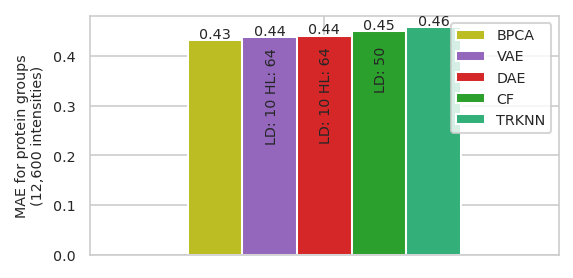

In [56]:
fig, ax = plt.subplots(figsize=(4, 2))  # size of the plot can be adjusted
ax = _to_plot.loc[[feature_names.name]].plot.bar(
    rot=0,
    ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY}\n({n_in_comparison:,} intensities)",
    # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
    color=COLORS_TO_USE,
    ax=ax,
    width=.7)
ax = vaep.plotting.add_height_to_barplot(ax, size=7)
ax = vaep.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=7)
ax.set_xticklabels([])
fname = args.out_figures / f'2_{group}_performance_test.pdf'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

In [57]:
dumps[fname.stem] = fname.with_suffix('.csv')
_to_plot_long = _to_plot.T
_to_plot_long = _to_plot_long.rename(
    {feature_names.name: 'metric_value'}, axis=1)
_to_plot_long['data level'] = feature_names.name
_to_plot_long = _to_plot_long.set_index('data level', append=True)
_to_plot_long.to_csv(fname.with_suffix('.csv'))

### Plot error by median feature intensity

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_test_errors_binned_by_feat_medians.pdf


,Sample ID,protein groups,model,MAE,bin,n_obs,intensity binned by median of protein groups
0,Sample_000,A0A075B6P5;P01615,BPCA,0.467,19,912,19\n(N=912)
1,Sample_000,A0A075B6P5;P01615,VAE,0.257,19,912,19\n(N=912)
2,Sample_000,A0A075B6P5;P01615,DAE,0.044,19,912,19\n(N=912)
3,Sample_000,A0A075B6P5;P01615,CF,0.350,19,912,19\n(N=912)
4,Sample_000,A0A075B6P5;P01615,TRKNN,0.422,19,912,19\n(N=912)
...,...,...,...,...,...,...,...
"62,995",Sample_209,Q9UGM5;Q9UGM5-2,BPCA,0.476,16,"1,913","16\n(N=1,913)"
"62,996",Sample_209,Q9UGM5;Q9UGM5-2,VAE,0.472,16,"1,913","16\n(N=1,913)"
"62,997",Sample_209,Q9UGM5;Q9UGM5-2,DAE,0.576,16,"1,913","16\n(N=1,913)"
"62,998",Sample_209,Q9UGM5;Q9UGM5-2,CF,0.597,16,"1,913","16\n(N=1,913)"


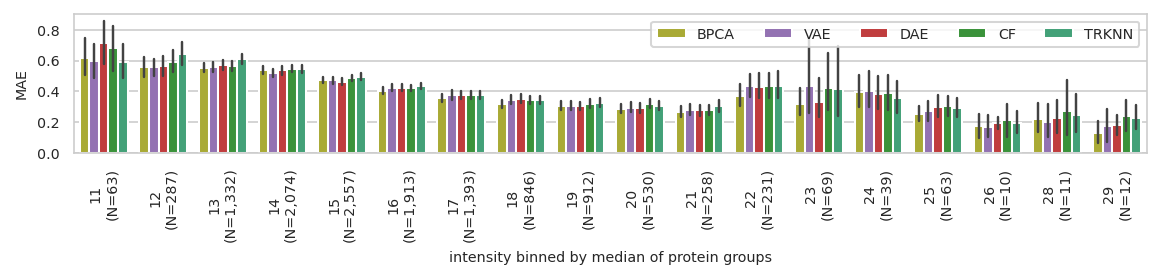

In [58]:
vaep.plotting.make_large_descriptors(7)
fig, ax = plt.subplots(figsize=(8, 2))

ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
    pred=pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC,
    palette=COLORS_TO_USE
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
vaep.plotting.make_large_descriptors(6)
fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned

In [59]:
# ! only used for reporting
plotted = vaep.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

,bin,model,mean,ci_low,ci_high
0,11\n(N=63),BPCA,0.619,0.505,0.743
1,11\n(N=63),VAE,0.596,0.484,0.712
2,11\n(N=63),DAE,0.716,0.578,0.860
3,11\n(N=63),CF,0.679,0.541,0.822
4,11\n(N=63),TRKNN,0.589,0.486,0.700
...,...,...,...,...,...
85,29\n(N=12),BPCA,0.133,0.063,0.211
86,29\n(N=12),VAE,0.175,0.080,0.281
87,29\n(N=12),DAE,0.180,0.116,0.249
88,29\n(N=12),CF,0.239,0.150,0.341


In [60]:
(errors_binned
 .set_index(
     ['model', errors_binned.columns[-1]]
 )
 .loc[ORDER_MODELS[0]]
 .sort_values(by=METRIC))

,Sample ID,protein groups,MAE,bin,n_obs
intensity binned by median of protein groups,,,,,
18\n(N=846),Sample_142,P09972,0.000,18,846
"15\n(N=2,557)",Sample_021,A0A0A0MT66,0.000,15,"2,557"
"14\n(N=2,074)",Sample_058,Q16853;Q16853-2,0.000,14,"2,074"
"16\n(N=1,913)",Sample_015,B7Z2R4;C9JR67;O43556;O43556-3;O43556-4,0.000,16,"1,913"
"15\n(N=2,557)",Sample_079,A6NCT7;Q07092;Q07092-2,0.000,15,"2,557"
...,...,...,...,...,...
"14\n(N=2,074)",Sample_011,P11597;P11597-2,5.771,14,"2,074"
"14\n(N=2,074)",Sample_184,F8WD41;Q15166,6.195,14,"2,074"
"17\n(N=1,393)",Sample_108,P27824;P27824-2,6.482,17,"1,393"


### Custom model selection

In [61]:
if SEL_MODELS:
    metrics = vaep.models.Metrics()
    test_metrics = metrics.add_metrics(
        pred_test[['observed', *SEL_MODELS]], key='test data')
    test_metrics = pd.DataFrame(test_metrics)[SEL_MODELS]
    test_metrics

    n_in_comparison = int(test_metrics.loc['N'].unique()[0])
    n_in_comparison

    _to_plot = test_metrics.loc[METRIC].to_frame().T
    _to_plot.index = [feature_names.name]
    _to_plot

    try:
        text = model_configs[["latent_dim", "hidden_layers"]].apply(
            build_text,
            axis=1)
    except KeyError:
        logger.warning("No PIMMS models in comparsion. Using empty text")
        text = pd.Series('', index=model_configs.columns)

    _to_plot.loc["text"] = text
    _to_plot = _to_plot.fillna('')
    _to_plot

    fig, ax = plt.subplots(figsize=(4, 2))
    ax = _to_plot.loc[[feature_names.name]].plot.bar(
        rot=0,
        ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY} ({n_in_comparison:,} intensities)",
        # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
        color=vaep.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS)),
        ax=ax,
        width=.7)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    ax = vaep.plotting.add_height_to_barplot(ax, size=5)
    ax = vaep.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=5)
    ax.set_xticklabels([])

    fname = args.out_figures / f'2_{group}_performance_test_sel.pdf'
    figures[fname.stem] = fname
    vaep.savefig(fig, name=fname)

    dumps[fname.stem] = fname.with_suffix('.csv')
    _to_plot_long = _to_plot.T
    _to_plot_long = _to_plot_long.rename(
        {feature_names.name: 'metric_value'}, axis=1)
    _to_plot_long['data level'] = feature_names.name
    _to_plot_long = _to_plot_long.set_index('data level', append=True)
    _to_plot_long.to_csv(fname.with_suffix('.csv'))

In [62]:
# custom selection
if SEL_MODELS:
    vaep.plotting.make_large_descriptors(7)
    fig, ax = plt.subplots(figsize=(8, 2))

    ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
        pred=pred_test[
            [TARGET_COL] + SEL_MODELS
        ],
        feat_medians=data.train_X.median(),
        ax=ax,
        metric_name=METRIC,
        feat_name=FEAT_NAME_DISPLAY,
        palette=vaep.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS))
    )
    # ax.set_ylim(0, 1.5)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    # for text in ax.legend().get_texts():
    #     text.set_fontsize(6)
    fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians_sel.pdf'
    figures[fname.stem] = fname
    vaep.savefig(ax.get_figure(), name=fname)
    plt.show(fig)

    dumps[fname.stem] = fname.with_suffix('.csv')
    errors_binned.to_csv(fname.with_suffix('.csv'))
    vaep.plotting.make_large_descriptors(6)
    # ax.xaxis.set_tick_params(rotation=0) # horizontal

    # ! only used for reporting
    plotted = vaep.plotting.errors.get_data_for_errors_by_median(
        errors=errors_binned,
        feat_name=FEAT_NAME_DISPLAY,
        metric_name=METRIC
    )
    plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
    display(plotted)

### Error by non-decimal number of intensity

- number of observations in parentheses.

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/2_1_test_errors_binned_by_int.pdf


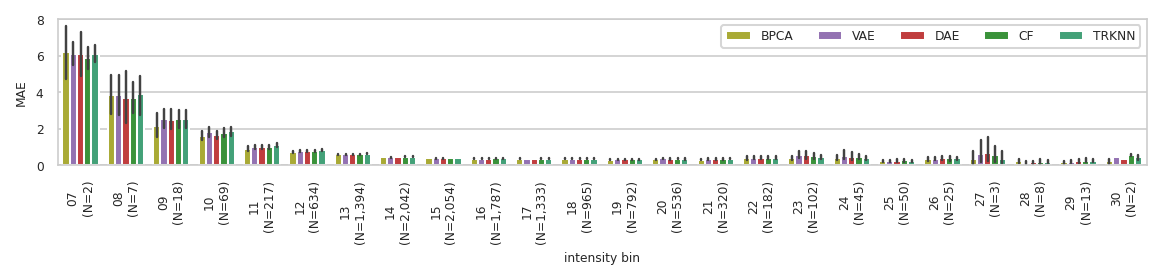

In [63]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_binned = vaep.plotting.errors.plot_errors_binned(
    pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    ax=ax,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_test_errors_binned_by_int.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

In [64]:
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

,Sample ID,protein groups,model,MAE,intensity bin
0,Sample_000,A0A075B6P5;P01615,BPCA,0.467,"17\n(N=1,333)"
1,Sample_000,A0A075B6P5;P01615,VAE,0.257,"17\n(N=1,333)"
2,Sample_000,A0A075B6P5;P01615,DAE,0.044,"17\n(N=1,333)"
3,Sample_000,A0A075B6P5;P01615,CF,0.350,"17\n(N=1,333)"
4,Sample_000,A0A075B6P5;P01615,TRKNN,0.422,"17\n(N=1,333)"


## Figures dumped to disk

In [65]:
figures

{'2_1_fake_na_val_test_splits': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_fake_na_val_test_splits.png'),
 '2_1_pred_corr_val_per_sample': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_pred_corr_val_per_sample.pdf'),
 '2_1_errors_binned_by_feat_median_val': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_errors_binned_by_feat_median_val.pdf'),
 '2_1_intensity_binned_top_4_models_test': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_intensity_binned_top_4_models_test.pdf'),
 '2_1_pred_corr_test_per_sample': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_pred_corr_test_per_sample.pdf'),
 '2_1_pred_corr_test_per_feat': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_pred_corr_test_per_feat.pdf'),
 '2_1_performance_test': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_performance_test.pdf'),
 '2_1_test_errors_binned_by_feat_medians': Path('runs/alzheimer_study_2023_11_v2/figures/2_1_test_errors_binned_by_feat_medians.pdf'),
 '2_1_test_errors_binned_by_int': Path('ru

In [66]:
dumps
print("done")

done
